In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt 
import math 
import itertools
# for making adjacency matrix
import networkx as nx

### This notebook displays most of the functions of the grapher in graph.py file for a visual representaiton of the code. In this particular file, I am taking example of file '339' but can be replicated for any file in the dataset.

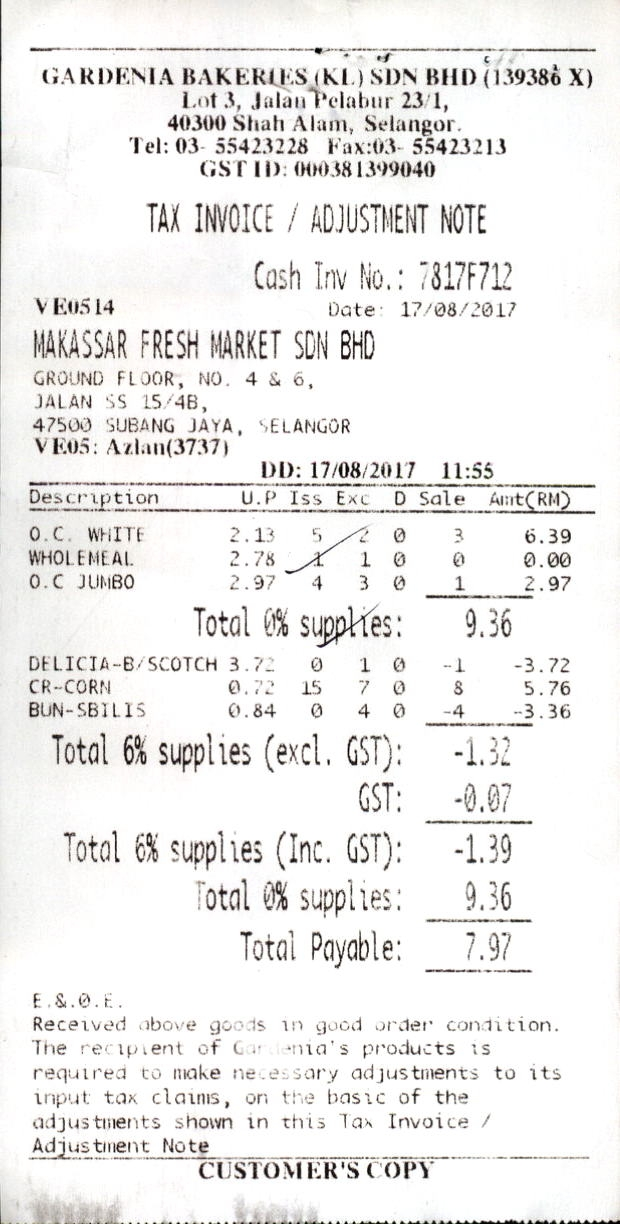

In [3]:
from PIL import Image

image = Image.open('../data/raw/img/339.jpg')
image

In [48]:
image = cv2.imread("../data/raw/img/339.jpg")
filename = '339.csv'

#Preprocess data

filepath = '../data/raw/box/'+filename
df = pd.read_csv(filepath, header=None, sep='\n')
df = df[0].str.split(',', expand=True)
temp = df.copy() 
temp[temp.columns] = temp.apply(lambda x: x.str.strip())

temp.fillna('', inplace=True)
temp[8]= temp[8].str.cat(temp.iloc[:,9:-1], sep =", ") 
temp[temp.columns] = temp.apply(lambda x: x.str.rstrip(", ,"))
temp = temp.loc[:, :8]
temp.drop([2,3,6,7], axis=1, inplace=True)
temp.columns = ['xmin','ymin','xmax','ymax','Object']
temp[['xmin','ymin','xmax','ymax']] = temp[['xmin','ymin','xmax','ymax']].apply(pd.to_numeric)

df = temp 
print(df)

    xmin  ymin  xmax  ymax                                     Object
0     39    64   595    88  GARDENIA BAKERIES (KL) SDN BHD (139386 X)
1    176    88   453   112                  LOT 3, JALAN PELABUR 23/1
2    164   113   464   135                 40300 SHAH ALAM, SELANGOR.
3    127   134   310   157                          TEL: 03- 55423228
4    195   157   439   180                       GST ID: 000381399040
..   ...   ...   ...   ...                                        ...
81   196  1159   437  1181                            CUSTOMER'S COPY
82   324   136   508   156                           FAX:03- 55423213
83   288   488   323   507                                        ISS
84   334   489   371   507                                        EXC
85   418   489   467   506                                       SALE

[86 rows x 5 columns]


In [5]:
image_height, image_width = image.shape[0], image.shape[1]

__Line formation:__

1) Sort words based on Top coordinate:<br>
2) Form lines as group of words which obeys the following:
    Two words (W_a and W_b) are in same line if:
        Top(W_a) <= Bottom(W_b) and Bottom(W_a) >= Top(W_b)<br>
3) Sort words in each line based on Left coordinate

This ensures that words are read from top left corner of the image first, 
going line by line from left to right and at last the final bottom right word of the page is read.




In [6]:
#sort df by 'top' coordinate. 
def line_formation(boundingbox_df):
    """
    args: 
        df with words and cordinates (xmin,xmax,ymin,ymax)
    returns: 
        df with words arranged in orientation top to bottom and left to right

    """
    assert type(df) == pd.DataFrame,f'object_map should be of type \
        {pd.DataFrame}. Received {type(boundingbox_df)}'
    assert type(image) == np.ndarray,f'image should be of type {np.ndarray} \
        . Received {type(image)}'

    assert 'xmin' in boundingbox_df.columns, '"xmin" not in object map'
    assert 'xmax' in boundingbox_df.columns, '"xmax" not in object map'
    assert 'ymin' in boundingbox_df.columns, '"ymin" not in object map'
    assert 'ymax' in boundingbox_df.columns, '"ymax" not in object map'
    assert 'Object' in boundingbox_df.columns, '"Object" column not in object map'
    #remove empty spaces both in front and behind
    df.columns = df.columns.str.strip()

    #further cleaning
    df.dropna(inplace=True)
    #sort from top to bottom
    df.sort_values(by=['ymin'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    #subtracting ymax by 1 to eliminate ambiguity of boxes being in both left and right 
    df["ymax"] = df["ymax"].apply(lambda x: x - 1)



 
    """

    _______________y axis__________
    |
    |                       top    
    x axis               ___________________
    |              left | bounding box      |  right
    |                   |___________________|           
    |                       bottom 
    |
    |


    iterate through the rows twice to compare them.
    remember that the axes are inverted.
    """
    master = []
    for idx, row in df.iterrows():

        #flatten the nested list 
        flat_master = list(itertools.chain(*master))
        #print(flat_master)
        #check to see if idx is in flat_master
        if idx not in flat_master:
            top_a = row['ymin']
            bottom_a = row['ymax']
            #top, bottom, right, left
            #coordinates = (row['ymin'],row['ymax'],row['xmin'],row['xmax'])
            #print(coordinates)

            #line will atleast have the word in it
            line = [idx]
            #line1=[row['Object']]
        
            for idx_2, row_2 in df.iterrows():
                #check to see if idx_2 is in flat_master removes ambiguity
                #picks higher cordinate one. 
                if idx_2 not in flat_master:
                #if not the same words
                    if not idx == idx_2:
                        top_b = row_2['ymin']
                        bottom_b = row_2['ymax'] 
                        if (top_a <= bottom_b) and (bottom_a >= top_b): 
                            line.append(idx_2)
                            #print(line)
            master.append(line)



    df2 = pd.DataFrame({'words_indices': master, 'line_number':[x for x in range(1,len(master)+1)]})

    #explode the list columns eg : [1,2,3]
    df2 = df2.set_index('line_number').words_indices.apply(pd.Series).stack()\
            .reset_index(level=0).rename(columns={0:'words_indices'})

    df2['words_indices'] = df2['words_indices'].astype('int')

    
    #put the line numbers back to the list
    final = df.merge(df2, left_on=df.index, right_on='words_indices')
    final.drop('words_indices', axis=1, inplace=True)
    
    
    """
    3) Sort words in each line based on Left coordinate
    """
    final2 =final.sort_values(by=['line_number','xmin'],ascending=True)\
            .groupby('line_number')\
            .head(len(final))\
            .reset_index(drop=True)


    return final2
    
line_formation(df)



,xmin,ymin,xmax,ymax,Object,line_number
0,39,64,595,87,GARDENIA BAKERIES (KL) SDN BHD (139386 X),1
1,176,88,453,111,"LOT 3, JALAN PELABUR 23/1",2
2,127,134,310,156,TEL: 03- 55423228,3
3,164,113,464,134,"40300 SHAH ALAM, SELANGOR.",3
4,324,136,508,155,FAX:03- 55423213,4
...,...,...,...,...,...,...
81,30,1062,564,1084,REQUIRED TO MAKE NECESSARY ADJUSTMENTS TO ITS,31
82,27,1085,472,1108,"INPUT TAX CLAIMS, ON THE BASIC OF THE",32
83,31,1111,496,1132,ADJUSTMENTS SHOWN IN THIS TAX INVOICE /,33
84,27,1134,213,1155,ADJUSTMENT NOTE,34


__Graph Formation__

For each word, perform the following:<br>
    - Check words which are in vertical projection with it.<br>
    - Calculate RD_l and RD_r for each of them <br>
    - Select nearest neighbour words in horizontal direction which have least magnitude of RD_l and RD_r,provided that those words do not have an edge in that direciton.<br>
    - In case, two words have same RD_l or RD_r, the word having higher top coordinate is chosen.<br>
    - Repeat steps from 2.1 to 2.3 similarly for retrieving nearest neighbour words in vertical direction by taking horizontal projection, calculating RD_t and RD_b and choosing words having higher left co-ordinate incase of ambiguity.<br>
    - Draw edges between word and its 4 nearest neighbours if they are available.<br>

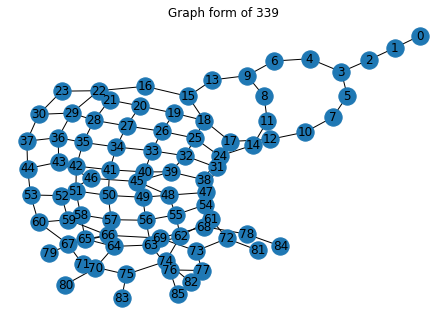

In [7]:
df = line_formation(df)


def grapher(df, export_graph =False):

    #horizontal edges formation
    #print(df)
    df.reset_index(inplace=True)
            
    
   
    grouped = df.groupby('line_number')
    
    #for undirected graph construction
    horizontal_connections = {}

    #left
    left_connections = {}    

    #right
    right_connections = {}

    for _,group in grouped:
        a = group['index'].tolist()
        b = group['index'].tolist()
        #b.reverse()
        #a = 0,1,2
        #2
        horizontal_connection = {a[i]:a[i+1] for i in range(len(a)-1) }

        #storing directional connections
        right_dict_temp = {a[i]:{'right':a[i+1]} for i in range(len(a)-1) }
        left_dict_temp = {b[i+1]:{'left':b[i]} for i in range(len(b)-1) }


        #add the indices in the dataframes
        for i in range(len(a)-1):
           df.loc[df['index'] == a[i], 'right'] = int(a[i+1])
           df.loc[df['index'] == a[i+1], 'left'] = int(a[i])
    
        left_connections.update(right_dict_temp)
        right_connections.update(left_dict_temp)
        horizontal_connections.update(horizontal_connection)


    dic1,dic2 = left_connections, right_connections
    
 
    
    #verticle connections formation


    bottom_connections = {}
    top_connections = {}

    for idx, row in df.iterrows():
        if idx not in bottom_connections.keys():
  
            right_a = row['xmax']
            left_a = row['xmin']

            for idx_2, row_2 in df.iterrows():

                #check for higher idx values 
             
                if idx_2 not in bottom_connections.values() and idx < idx_2:
                    #if idx_2 not in bottom_connections.values() and (idx != idx_2):
                        right_b = row_2['xmax']
                        left_b = row_2['xmin'] 
                        if (left_b <= right_a) and (right_b >= left_a): 
                            bottom_connections[idx] = idx_2
                            
                            top_connections[idx_2] = idx

                            #add it to the dataframe
                            df.loc[df['index'] == idx , 'bottom'] = idx_2
                            df.loc[df['index'] == idx_2, 'top'] = idx 

                            #print(bottom_connections)

                            #once the condition is met, break the loop to reduce redundant time complexity
                            break 
                    
                            #below = True 

    # print(df)


    # print('bottom connections:', bottom_connections)
    # # print(top_connections)
    # print('horizontal connections:', horizontal_connections)


    #combining both 
    result = {}
    dic1 = horizontal_connections
    dic2 = bottom_connections

    for key in (dic1.keys() | dic2.keys()):
        if key in dic1: result.setdefault(key, []).append(dic1[key])
        if key in dic2: result.setdefault(key, []).append(dic2[key])
    #print(result)

    G = nx.from_dict_of_lists(result)
  

    if export_graph:
        file, _ = os.path.splitext(filename)
        plot_path ='../../figures/' + file + 'plain_graph' '.jpg'
        if not os.path.exists(plot_path):
            layout = nx.kamada_kawai_layout(G)        
            nx.draw(G, layout, with_labels=True)
           # plt.savefig(plot_path, format="PNG")
            plt.title(f'Graph form of {file}')
            plt.show()
            
        

    return result, G, df 



#features calculation

dict_graph, graph, processed_df = grapher(df, export_graph=True)

In [8]:
dict_graph 

{0: [1],
 1: [2],
 2: [3],
 3: [4, 5],
 4: [6],
 5: [7],
 6: [9],
 7: [10],
 8: [9, 11],
 9: [13],
 10: [12],
 11: [14],
 12: [17],
 13: [15],
 14: [24],
 15: [16, 18],
 16: [22],
 17: [18, 31],
 18: [19, 25],
 19: [20, 26],
 20: [21, 27],
 21: [22, 28],
 22: [23, 29],
 23: [30],
 24: [25, 38],
 25: [26, 32],
 26: [27, 33],
 27: [28, 34],
 28: [29, 35],
 29: [30, 36],
 30: [37],
 31: [32, 47],
 32: [33, 39],
 33: [34, 40],
 34: [35, 41],
 35: [36, 42],
 36: [37, 43],
 37: [44],
 38: [39, 54],
 39: [40, 45],
 40: [41, 49],
 41: [42, 50],
 42: [43, 51],
 43: [44, 46],
 44: [53],
 45: [46, 48],
 46: [52],
 47: [48, 61],
 48: [49, 55],
 49: [50, 56],
 50: [51, 57],
 51: [52, 58],
 52: [53, 59],
 53: [60],
 54: [55, 68],
 55: [56, 62],
 56: [57, 63],
 57: [58, 64],
 58: [59, 65],
 59: [60, 66],
 60: [67],
 61: [62, 72],
 62: [63, 74],
 63: [64, 76],
 64: [65, 70],
 65: [66, 79],
 66: [67, 69],
 67: [71],
 68: [69, 78],
 69: [73],
 70: [71, 80],
 71: [75],
 72: [73, 81],
 73: [77],
 74: [75,

In [9]:
graph

In [10]:
processed_df

,index,xmin,ymin,xmax,ymax,Object,line_number,right,left,bottom,top
0,0,39,64,595,86,GARDENIA BAKERIES (KL) SDN BHD (139386 X),1,NaN,NaN,1.0,NaN
1,1,176,88,453,110,"LOT 3, JALAN PELABUR 23/1",2,NaN,NaN,2.0,0.0
2,2,164,113,464,133,"40300 SHAH ALAM, SELANGOR.",3,NaN,NaN,3.0,1.0
3,3,127,134,310,155,TEL: 03- 55423228,4,4.0,NaN,5.0,2.0
4,4,324,136,508,154,FAX:03- 55423213,4,NaN,3.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
81,81,30,1062,564,1083,REQUIRED TO MAKE NECESSARY ADJUSTMENTS TO ITS,31,NaN,NaN,NaN,72.0
82,82,27,1085,472,1107,"INPUT TAX CLAIMS, ON THE BASIC OF THE",32,NaN,NaN,NaN,74.0
83,83,31,1111,496,1131,ADJUSTMENTS SHOWN IN THIS TAX INVOICE /,33,NaN,NaN,NaN,75.0
84,84,27,1134,213,1154,ADJUSTMENT NOTE,34,NaN,NaN,NaN,78.0


In [11]:
def relative_distance(df):
    #RDL and RDT are negative while RDR and RDB are positive
    plot_df = df.copy() 


    for index in df['index'].to_list():

        right_index = df.loc[df['index'] == index, 'right'].values[0]
        left_index = df.loc[df['index'] == index, 'left'].values[0]
        bottom_index = df.loc[df['index'] == index, 'bottom'].values[0]
        top_index = df.loc[df['index'] == index, 'top'].values[0]

        #rd_r = (right_word_xmin - left_word_xmax)/image_width

        #check if it is nan value 
        if np.isnan(right_index) == False: 
            right_word_left = df.loc[df['index'] == right_index, 'xmin'].values[0]
            source_word_right = df.loc[df['index'] == index, 'xmax'].values[0]

            df.loc[df['index'] == index, 'rd_r'] = (right_word_left - source_word_right)/image_width

            """
            for plotting purposes
            getting the mid point of the values to draw the lines for the graph
            mid points of source and destination for the bounding boxes
            """

            right_word_x_max = df.loc[df['index'] == right_index, 'xmax'].values[0]
            right_word_y_max = df.loc[df['index'] == right_index, 'ymax'].values[0]
            right_word_y_min = df.loc[df['index'] == right_index, 'ymin'].values[0]

            #source_word_x_min = df.loc[df['index'] == index, 'xmin'].values[0]

            #source_word_y_min = df.loc[df['index'] == index, 'xmin'].values[0]
            #source_word_y_min = df.loc[df['index'] == index, 'xmin'].values[0]



            plot_df.loc[df['index'] == index, 'destination_x_hori'] = (right_word_x_max + right_word_left)/2
            plot_df.loc[df['index'] == index, 'destination_y_hori'] = (right_word_y_max + right_word_y_min)/2
            #plot_df.loc[df['index'] == index, 'source_x_hori'] = (source_word_right - source_word_x_min)/2
            #plot_df.loc[df['index'] == index, 'source_y_hori'] = (source_word_right - source_word_min)/2



        if np.isnan(left_index) == False:
            left_word_right = df.loc[df['index'] == left_index, 'xmax'].values[0]
            source_word_left = df.loc[df['index'] == index, 'xmin'].values[0]

            df.loc[df['index'] == index, 'rd_l'] = (left_word_right - source_word_left)/image_width
        


        if np.isnan(bottom_index) == False:
            bottom_word_top = df.loc[df['index'] == bottom_index, 'ymin'].values[0]
            source_word_bottom = df.loc[df['index'] == index, 'ymax'].values[0]

            df.loc[df['index'] == index, 'rd_b'] = (bottom_word_top - source_word_bottom)/image_height


            #for plotting purposes
            bottom_word_top_max = df.loc[df['index'] == bottom_index, 'ymax'].values[0]
            #source_word_min = df.loc[df['index'] == index, 'ymin'].values[0]
            bottom_word_x_max = df.loc[df['index'] == bottom_index, 'xmax'].values[0]
            bottom_word_x_min = df.loc[df['index'] == bottom_index, 'xmin'].values[0]


            plot_df.loc[df['index'] == index, 'destination_y_vert'] = (bottom_word_top_max + bottom_word_top)/2
            plot_df.loc[df['index'] == index, 'destination_x_vert'] = (bottom_word_x_max + bottom_word_x_min)/2
            #plot_df.loc[df['index'] == index, 'source_y_vert'] = (source_word_bottom - source_word_min)/2


        if np.isnan(top_index) == False:
            top_word_bottom = df.loc[df['index'] == top_index, 'ymax'].values[0]
            source_word_top = df.loc[df['index'] == index, 'ymin'].values[0]

            df.loc[df['index'] == index, 'rd_t'] = (top_word_bottom - source_word_top)/image_height


    #replace all tne NaN values with '0' meaning there is nothing in that direction
    df[['rd_r','rd_b','rd_l','rd_t']] = df[['rd_r','rd_b','rd_l','rd_t']].fillna(0)
    

    plot_df['rd_r'] = df['rd_r']
    plot_df['rd_b'] = df['rd_b']
  
    return df, plot_df 


In [12]:
df, plot_df = relative_distance(processed_df)
print(plot_df)

    index  xmin  ymin  xmax  ymax  \
0       0    39    64   595    86   
1       1   176    88   453   110   
2       2   164   113   464   133   
3       3   127   134   310   155   
4       4   324   136   508   154   
..    ...   ...   ...   ...   ...   
81     81    30  1062   564  1083   
82     82    27  1085   472  1107   
83     83    31  1111   496  1131   
84     84    27  1134   213  1154   
85     85   196  1159   437  1179   

                                           Object  line_number  right  left  \
0       GARDENIA BAKERIES (KL) SDN BHD (139386 X)            1    NaN   NaN   
1                       LOT 3, JALAN PELABUR 23/1            2    NaN   NaN   
2                      40300 SHAH ALAM, SELANGOR.            3    NaN   NaN   
3                               TEL: 03- 55423228            4    4.0   NaN   
4                                FAX:03- 55423213            4    NaN   3.0   
..                                            ...          ...    ...   ...   
81

In [13]:
def show_document_graph(plot_df, img, export_image=False):
    for idx, row in plot_df.iterrows():
        #bounding box
        cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 255), 2)

        if np.isnan(row['destination_x_vert']) == False:
            source_x = (row['xmax'] + row['xmin'])/2
            source_y = (row['ymax'] + row['ymin'])/2
            

            cv2.line(img, 
                    (int(source_x), int(source_y)),
                    (int(row['destination_x_vert']), int(row['destination_y_vert'])), 
                    (0,255,0), 1)


            text = "{:.3f}".format(row['rd_b'])
            text_coordinates = ( int((row['destination_x_vert'] + source_x)/2) , int((row['destination_y_vert'] +source_y)/2))     
            cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

            #text_coordinates = ((row['destination_x_vert'] + source_x)/2 , (row['destination_y_vert'] +source_y)/2)
        
        if np.isnan(row['destination_x_hori']) == False:
            source_x = (row['xmax'] + row['xmin'])/2
            source_y = (row['ymax'] + row['ymin'])/2

            cv2.line(img, 
                (int(source_x), int(source_y)),
                (int(row['destination_x_hori']), int(row['destination_y_hori'])), \
                (0,255,0), 1)

            text = "{:.3f}".format(row['rd_r'])
            text_coordinates = (int((row['destination_x_hori'] + source_x)/2) , int((row['destination_y_hori'] +source_y)/2))     
            cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

        


    # cv2.imshow("image", img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    if export_image:
        file, _ = os.path.splitext(filename)
        plot_path ='../../figures/' + file + 'docu_graph' '.jpg'
        if not os.path.exists(plot_path):
            cv2.imwrite(plot_path, img)
            

  

print(dict_graph)

show_document_graph(plot_df,image, export_image=True)

{0: [1], 1: [2], 2: [3], 3: [4, 5], 4: [6], 5: [7], 6: [9], 7: [10], 8: [9, 11], 9: [13], 10: [12], 11: [14], 12: [17], 13: [15], 14: [24], 15: [16, 18], 16: [22], 17: [18, 31], 18: [19, 25], 19: [20, 26], 20: [21, 27], 21: [22, 28], 22: [23, 29], 23: [30], 24: [25, 38], 25: [26, 32], 26: [27, 33], 27: [28, 34], 28: [29, 35], 29: [30, 36], 30: [37], 31: [32, 47], 32: [33, 39], 33: [34, 40], 34: [35, 41], 35: [36, 42], 36: [37, 43], 37: [44], 38: [39, 54], 39: [40, 45], 40: [41, 49], 41: [42, 50], 42: [43, 51], 43: [44, 46], 44: [53], 45: [46, 48], 46: [52], 47: [48, 61], 48: [49, 55], 49: [50, 56], 50: [51, 57], 51: [52, 58], 52: [53, 59], 53: [60], 54: [55, 68], 55: [56, 62], 56: [57, 63], 57: [58, 64], 58: [59, 65], 59: [60, 66], 60: [67], 61: [62, 72], 62: [63, 74], 63: [64, 76], 64: [65, 70], 65: [66, 79], 66: [67, 69], 67: [71], 68: [69, 78], 69: [73], 70: [71, 80], 71: [75], 72: [73, 81], 73: [77], 74: [75, 82], 75: [83], 76: [77, 85], 78: [84]}


In [14]:

def make_adjacency(graph_dict):#, text_list):
    '''
        Function to make an adjacency matrix from a networkx graph object
        as well as padded feature matrix
        Args:
            G: networkx graph object
            
            text_list: list,
                        of text entities:
                        ['Tax Invoice', '1/2/2019', ...]
        Returns:
            A: Adjacency matrix as np.array
            X: Feature matrix as numpy array for input graph
    '''
    G = nx.from_dict_of_lists(graph_dict)
    adj_sparse = nx.adjacency_matrix(G)

    # preprocess the sparse adjacency matrix returned by networkx function
    A = np.array(adj_sparse.todense())
    #A = self._pad_adj(A)

    # preprocess the list of text entities
    #feat_list = list(map(self._get_text_features, text_list))
    #feat_arr = np.array(feat_list)
    #X = self._pad_text_features(feat_arr)

    return A

adjacancy_matrix = make_adjacency(dict_graph)

In [15]:
adjacancy_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [16]:
adjacancy_matrix.shape

(86, 86)